# Representing spectra

In this notebook I explore some basic practical questions on how to treat and use spectra. It can often be frustrating trying to make spectra agree between methods (e.g. FFT vs CWT vs PSD) or between spectra with different properties. These questions can compound when trying to directly generate a significance test when using a Monte-Carlo or idealized curve. The other notebooks in this collection spend a considerable amount of effort developing significance tests for CWT, as idealized significance testing for anything besides white noise have not been developed. These notebooks build on the basic practical knowledge explored here.

In [1]:
# Math libraries
import numpy as np
import colorednoise as cn
import pycwt
import scipy.integrate as integrate
from matplotlib import mlab

# OS interaction
import sys
# Add the other files from these helper functions
sys.path.append('../helper_functions')
sys.path.append('../figures')

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Local pycwt helper functions
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt

# Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper")

# Define a default color palette (this should be fairly color blind friendly)
tol_bright_reorder = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright_reorder))

<a id='artificial-time-series'></a>
# 1. Artificially generated time series

It is necessary to have some artificially generated time series to compare against when doing

- Monte-Carlo significant tests
- Fitting a time series
- Testing functions

Here we show two methods for doing this.

<a id='infinite-time-series'></a>
## 1.1 Implement colored noise test spectra using the "colorednoise" python package

When directly simulating a colored noise process, the initialization, e.g. of the Markov chain, causes changes in the slope of the spectra at the longer time scales. The colored noise python package generates time series that have the properties of an "infinitely" long sampled process. This is a theoretical advantage over directly simulating random number generator for white noise or using a Markov chain to model the red noise.

Generate:

1) White noise
2) Red noise
3) Pink noise


Text(0.5, 1.0, 'Colored noise for anlaysis')

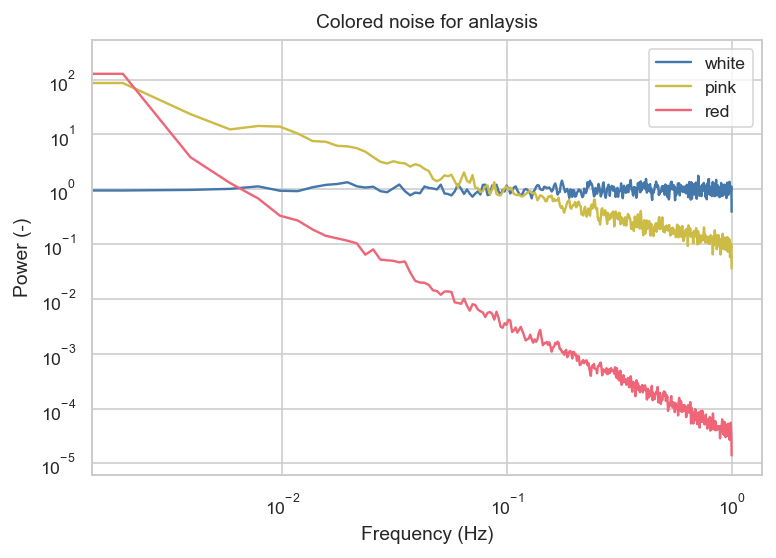

In [3]:
N = 2**15 # number of samples to generate
y_white = cn.powerlaw_psd_gaussian(0, N)
y_pink = cn.powerlaw_psd_gaussian(1, N)
y_red = cn.powerlaw_psd_gaussian(2, N)

# Plot the Power Spectral Density with Matplotlib
s, f = mlab.psd(y_white, NFFT=2**10)
plt.loglog(f, s, label='white')

s, f = mlab.psd(y_pink, NFFT=2**10)
plt.loglog(f, s, label='pink')

s, f = mlab.psd(y_red, NFFT=2**10)
plt.loglog(f, s, label='red')

# Format the plot
plt.gca().legend()
plt.gca().set_ylabel('Power (-)')
plt.gca().set_xlabel('Frequency (Hz)')
plt.gca().set_title('Colored noise for anlaysis')

<a id='finite-time-series'></a>
## 1.2 Implement AR(1) process from a finite length time series

The above uses the theoretical noise time series. What happens if we generate the AR(1) process numerically? `cwt_stat` has a built-in function that we can take advantage of for this process.

In [4]:
# N = number of samples
# 0.9 = auto-correlation between points
# 1 = variance of the white noise
# init_n_len = number of `N` length time series to generate as initialization
y_red_ar1 = cwt_stat.ar1_generator(N, 0.9, 1, init_n_len=15)


Text(0.5, 1.0, 'Colored noise for anlaysis')

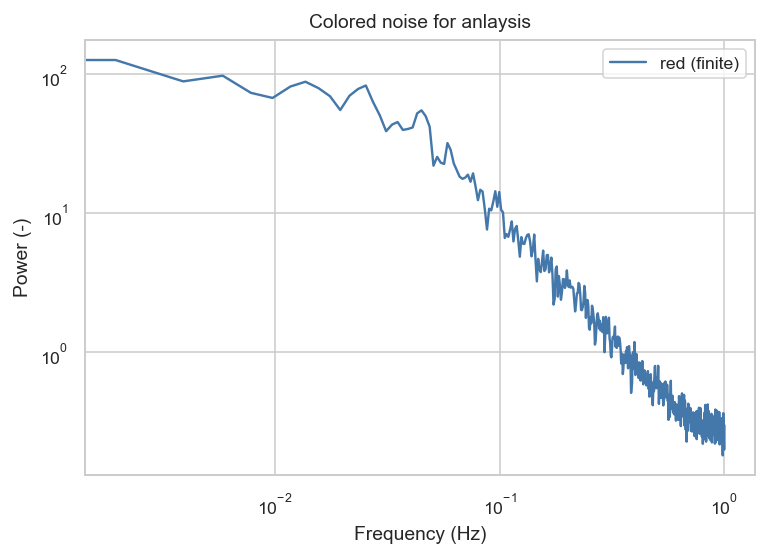

In [5]:
# Plot the Power Spectral Density with Matplotlib
s, f = mlab.psd(y_red_ar1, NFFT=2**10)
plt.loglog(f, s, label='red (finite)')

# Format the plot
plt.gca().legend()
plt.gca().set_ylabel('Power (-)')
plt.gca().set_xlabel('Frequency (Hz)')
plt.gca().set_title('Colored noise for anlaysis')

The power spectra of the finite-length AR(1) process is distorted. The flat region at longer frequencies than $10^{-1}$ approaches the white noise spectra. The highest frequencies also flatten (most easily visible when using the shortest fft window). The region between these two distortions follows the slope we would expect for a pink noise process.

This distorion in the power spectra for a finite-length AR(1) process is actually well-known (Vamos et al., 2007). But, this has a substantial impact on the resulting spectra and signficance tests when implementing AR(1) processes in a Monte-Carlo simulation.

<a id='Pre-treating'></a>
# 2 Pre-treating time series

Data for creating spectra need to be pre-processed when comparing between methods (e.g. FFT vs CWT) or time series with different properties. The `cwt_stat.standardize()` function is designed to accomodate several different methods of standardizing the data:

1) Normal standardization by the standard deviation
2) Removing the mean
3) Linear detrending
4) Band pass filter (the helper functions only have a high pass filter implemented)

(3) and (4) are also be called __pre-whitening__, which is a common step of processing spectra by removing obvious oscillations that are not of interest (e.g. the diurnal cycle). This allows other spectral peaks to be more easily identified and facilitates better estimating other time series properties. 

To verify that no bugs or misimplementations are present in the helper function, the resulting time series should all have a variance of 1, which is the desired behavior.

The colored noise will not have a mean of zero nor a standard deviation of 1 (except for white noise), so it needs to be standardized.

When using the cwt helper functions, one must either standardize the signal (recommended) or scale the global power by the variance, especially when comparing to a different spectral method (i.e. FFT).

## 2.1 Standardization by the standard deviation

Variance before standardizing (original)
0.719038027068301
Variance after standardizing
1.0


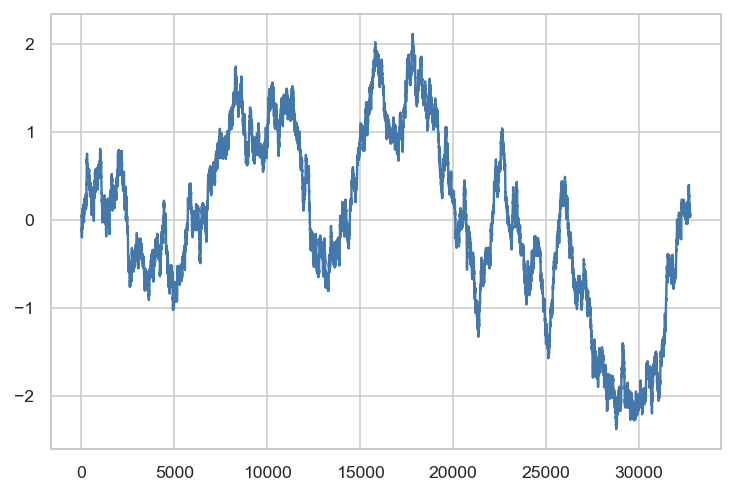

In [6]:
signal = y_red
plt.figure()
print('Variance before standardizing (original)')
print(np.std(signal) ** 2)

signal_norm = cwt_stat.standardize(signal, **{'standardize': True, 'detrend': False, 'remove_mean': True})
plt.plot(signal_norm, label='Standardized')
print('Variance after standardizing')
print(np.std(signal_norm) ** 2)


We can see that the "infinite" white noise process does not behave precisely as we anticipate.

## 2.2 Standardization + detrending

A quick demonstration here is the standarization with detrending.

Incorrect variance (no standardization after detrending)
0.5622031995718183
Correct variance (standardizing after detrending)
1.0


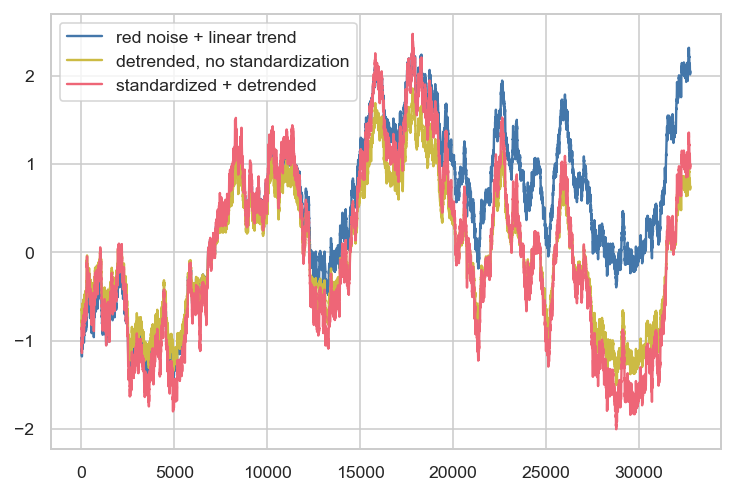

In [7]:
signal = y_red + np.arange(N) / N * 3 - 1
plt.figure()
plt.plot(signal, label='red noise + linear trend')

signal_norm = cwt_stat.standardize(signal, **{'standardize': False, 'detrend': True})
plt.plot(signal_norm, label='detrended, no standardization')
print('Incorrect variance (no standardization after detrending)')
print(np.std(signal_norm) ** 2)

signal_norm = cwt_stat.standardize(signal, **{'standardize': True, 'detrend': True})
plt.plot(signal_norm, label='standardized + detrended')
print('Correct variance (standardizing after detrending)')
print(np.std(signal_norm) ** 2)
plt.gca().legend()

## 2.3 Standardization + band pass filtering

This is also knwon as __pre-whitening__

First we need to generate a signal with some obvious fluctuations with well defined frequencies to make the visualization simpler.

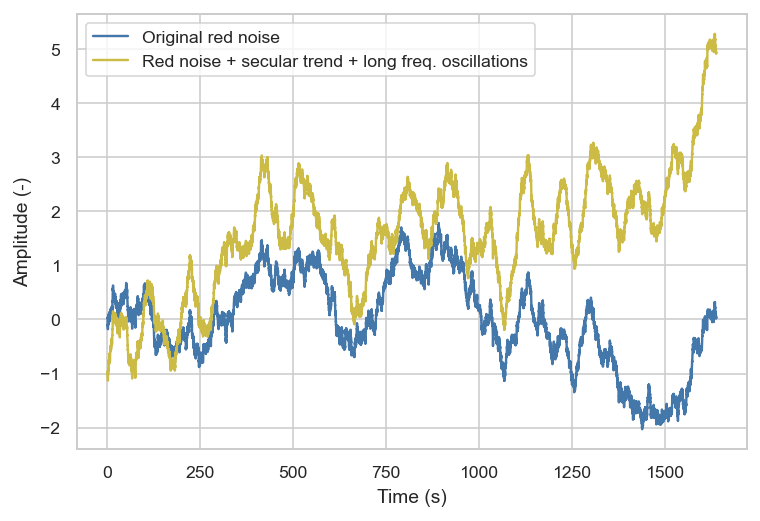

In [8]:
fs = 20 # Hz
t = np.arange(N) / fs
plt.plot(t, y_red, label='Original red noise')

# Make up some secular trend and add it to the red noise
signal = y_red + t * 0.003 - 1

# Make up some long frequency modulations
f_x1 = 1 / 100 # frequency of feature 1
f_x2 = 1 / 1500 # frequency of feature 2
f_x3 = 1 / 1200 # frequency of feature 3
amp = 0.5
osc = (amp * np.sin(t * f_x1 * np.pi * 2)
       + amp * np.sin(t * f_x2 * np.pi * 2)
       + amp * np.sin(t * f_x3 * np.pi * 2)
      )

# Add the modulations to the red noise data + secular trend
signal = signal + osc
plt.plot(t, signal, label='Red noise + secular trend + long freq. oscillations')
ax = plt.gca()
ax.set_ylabel('Amplitude (-)')
ax.set_xlabel('Time (s)')
plt.gca().legend()

Now we highpass the artificial time series using a cutoff frequency that is slower than the first artifial feature. The white noise is still preserved, but the longer time scale red noise is removed.

Variance after bandpass filter
1.0


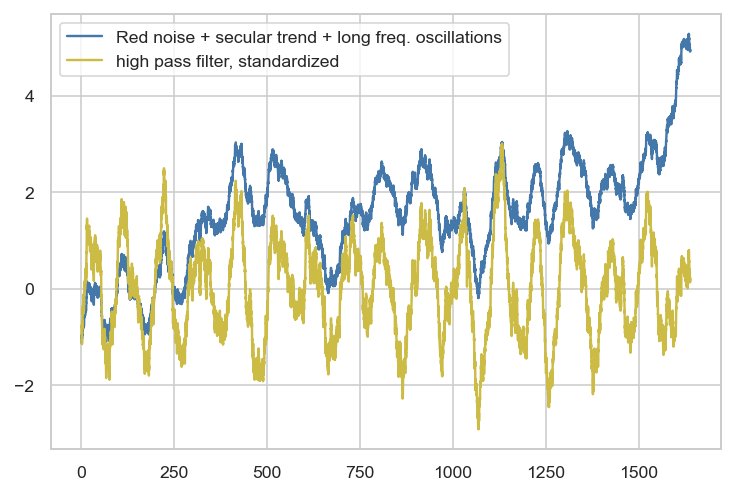

In [9]:
# Preserve the first artificial feature to aid visualization using a cutoff 
f_coff = 1 / 200
bandpass_kwargs = {'fs': fs, 'cutoff': f_coff}
signal_norm = cwt_stat.standardize(
    signal, **{
        'standardize': True, 
        'bandpass_filter': True,
        'bandpass_kwargs': bandpass_kwargs,
        'remove_mean': False,
        'detrend': False,
    }
)
plt.plot(t, signal, label='Red noise + secular trend + long freq. oscillations')
plt.plot(t, signal_norm, label='high pass filter, standardized')
print('Variance after bandpass filter')
print(np.std(signal_norm) ** 2)

plt.gca().legend()

<a id='Window Crafting'></a>
# 3. Window Crafting

In Power Spectral Density (PSD) and Continuous Wavelet Transform (CWT) analysis, window crafting can be important to target processes at appropriate scales.

<a id='Window Craftin PSD'></a>
## 3.1 Power Spectral Density and Window Crafting

When integrating a power spectra over all frequencies the result should be the variance of the input signal. However, this is only true in the case of a global integration. This outcome cannot be gauranteed when doing a bandlimited integration, as is the case when performing this step numerically. This difficulty makes it important to carefully craft the spectra window/properties. Small windows with overlap better resolve the smallest scales/highest frequencies since we have many samples. However, this comes at the expense of not being able to resolve the largest scales/lowest frequencies. Using a longer window to capture the longer frequencies results in poorly resolving the highest frequencies, resulting in a trade-off. A window that is too small or too large will result in some poor spectral properties e.g. not integrating to equal the variance of the signal.

### 3.1.1 White noise

PSD(f_short)/sigma**2 = 0.99
PSD(f_medium)/sigma**2 = 1.01
PSD(f_long)/sigma**2 = 0.99


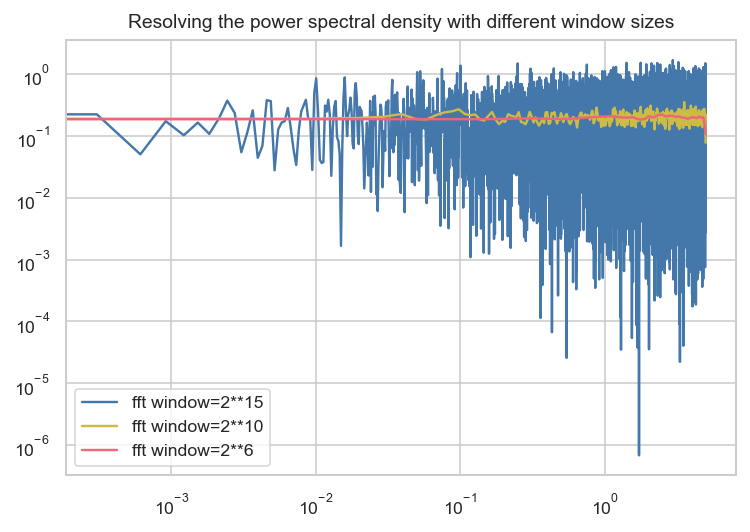

In [21]:
# Choose our example signal
signal = y_white
signal_var = signal.std() ** 2
# Sampling frequency (Hz)
fs = 10
# The time step (s) and time series
dt = 1 / fs
time = np.arange(0, N * dt, dt)

# Fourier Spectra using a short, medium, and long window
s_short, f_short = mlab.psd(signal, NFFT=2**6, Fs=fs)
s_med, f_med = mlab.psd(signal, NFFT=2**10, Fs=fs)
s_long, f_long = mlab.psd(signal, NFFT=2**15, Fs=fs)
# Integrate the spectra to determine if it is equal to the variance
print('PSD(f_short)/sigma**2 = {:1.2f}'.format(integrate.trapezoid(s_short / signal_var, f_short)))
print('PSD(f_medium)/sigma**2 = {:1.2f}'.format(integrate.trapezoid(s_med / signal_var, f_med)))
print('PSD(f_long)/sigma**2 = {:1.2f}'.format(integrate.trapezoid(s_long / signal_var, f_long)))

plt.loglog(f_long, s_long / signal_var, label='fft window=2**15')
plt.loglog(f_med, s_med / signal_var, label='fft window=2**10')
plt.loglog(f_short, s_short / signal_var, label='fft window=2**6')

plt.gca().set_title('Resolving the power spectral density with different window sizes')
plt.gca().legend()

For white noise processes the window crafting is not hugely importatn. We can get away using pretty much any window size.

### 3.1.2 Red and Pink Noise

PSD(f_short)/sigma**2 = 0.79
PSD(f_medium)/sigma**2 = 0.90
PSD(f_long)/sigma**2 = 0.94


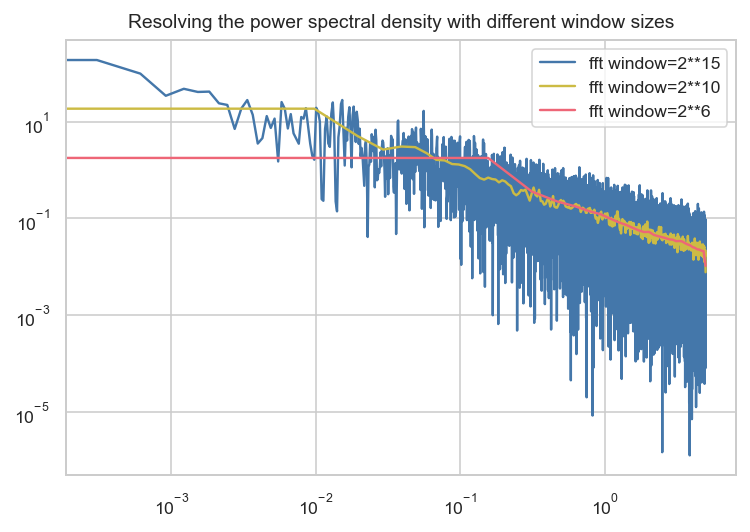

In [24]:
# Choose our example signal
signal = y_pink
signal_var = signal.std() ** 2
# Sampling frequency (Hz)
fs = 10
# The time step (s) and time series
dt = 1 / fs
time = np.arange(0, N * dt, dt)

# Fourier Spectra using a short, medium, and long window
s_short, f_short = mlab.psd(signal, NFFT=2**6, Fs=fs)
s_med, f_med = mlab.psd(signal, NFFT=2**10, Fs=fs)
s_long, f_long = mlab.psd(signal, NFFT=2**15, Fs=fs)
# Integrate the spectra to determine if it is equal to the variance
print('PSD(f_short)/sigma**2 = {:1.2f}'.format(integrate.trapezoid(s_short / signal_var, f_short)))
print('PSD(f_medium)/sigma**2 = {:1.2f}'.format(integrate.trapezoid(s_med / signal_var, f_med)))
print('PSD(f_long)/sigma**2 = {:1.2f}'.format(integrate.trapezoid(s_long / signal_var, f_long)))

plt.loglog(f_long, s_long / signal_var, label='fft window=2**15')
plt.loglog(f_med, s_med / signal_var, label='fft window=2**10')
plt.loglog(f_short, s_short / signal_var, label='fft window=2**6')

plt.gca().set_title('Resolving the power spectral density with different window sizes')
plt.gca().legend()

Most of the power is contained at the lowest frequencies for the pink noise spectrum, meaning that the ability to resolve the variance from the power spectrum is dictated by the ability to resolve the longest scales. Resolving the longest frequencies comes at the expense of not representing the shortest frequencies.

PSD(f_medium)/sigma**2 = 0.48 for the first 10 spectral points
PSD(f_medium)/sigma**2 = 0.92 for the entire spectrum


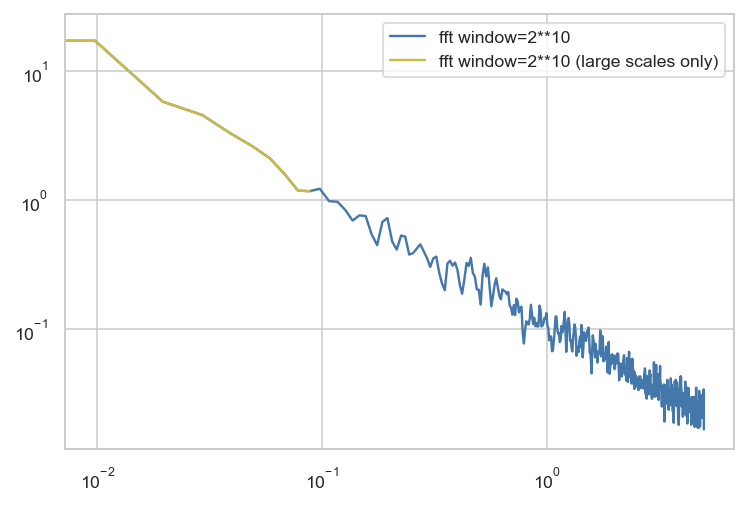

In [12]:
plt.loglog(f_med, s_med / signal_var, label='fft window=2**10')
plt.loglog(f_med[:10], s_med[:10] / signal_var, label='fft window=2**10 (large scales only)')
plt.legend()

power_lrgscl = integrate.trapezoid(s_med[:10], f_med[:10]) / signal_var
power_all = integrate.trapezoid(s_med, f_med) / signal_var
print('PSD(f_medium)/sigma**2 = {:1.2f} for the first 10 spectral points'.format(power_lrgscl))
print('PSD(f_medium)/sigma**2 = {:1.2f} for the entire spectrum'.format(power_all))

## 3.2 CWT and Window Crafting

The same principles that are relevant to the Power Spectral Density window crafting above are relevant when calculating wavelet spectra.

CWT/sigma**2 / sqrt(dt) = 1.02 (13 octaves, 7 suboctaves)
CWT/sigma**2 / sqrt(dt) = 0.81 (10 octaves, 7 suboctaves)


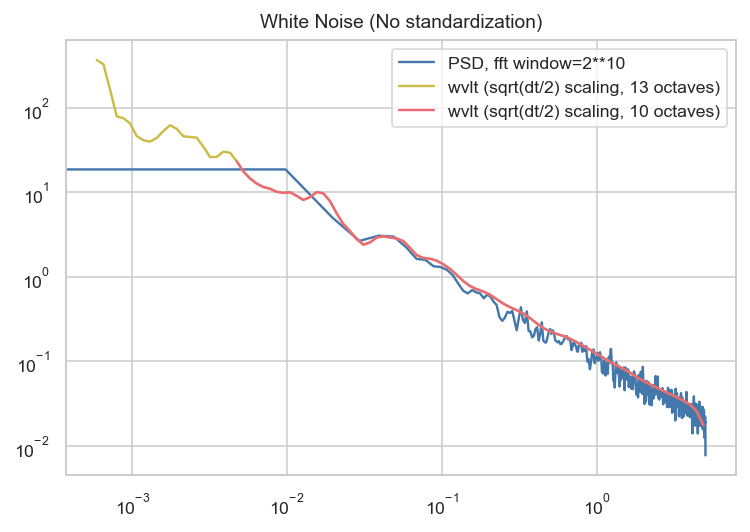

In [25]:
mother = pycwt.Morlet()

# Compare to the FFT spectra
plt.loglog(f_med, s_med / signal_var, label='PSD, fft window=2**10')

# Perform the CWT analysis for a large number of octaves
octaves = [1 / 7, 13 / (1 / 7)]  
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': True, 'detrend': False, 'remove_mean': False},
    significance_test=False,
)

# Integrate the spectra to determine if it is equal to the variance
print(
    'CWT/sigma**2 / sqrt(dt) = {:1.2f} (13 octaves, 7 suboctaves)'.format(
        integrate.trapezoid(
            np.flip(power.mean(axis=1)) * np.sqrt(dt / 2),
            np.flip(1 / period)
        )
    )
)

plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt / 2), label='wvlt (sqrt(dt/2) scaling, 13 octaves)')

# Perform the CWT analysis for a small number of octaves
octaves = [1 / 7, 10 / (1 / 7)]  
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': True, 'detrend': False, 'remove_mean': False},
    significance_test=False,
)

# Integrate the spectra to determine if it is equal to the variance
print(
    'CWT/sigma**2 / sqrt(dt) = {:1.2f} (10 octaves, 7 suboctaves)'.format(
        integrate.trapezoid(
            np.flip(power.mean(axis=1)) * np.sqrt(dt / 2),
            np.flip(1 / period)
        )
    )
)
plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt / 2), label='wvlt (sqrt(dt/2) scaling, 10 octaves)')

plt.gca().set_title('White Noise (No standardization)')
plt.gca().legend()

The same issues as before, but not quite as bad since the CWT has a better representation across the entire spectrum, especially at the longest frequencies.

You may have noticed that I scaled the CWT spectral power by $\sqrt(\frac{dt}{2})$. This is necessary to match the Power Spectral Density. I explore that next.

<a id='Comparing Spectra'></a>
## 4 Comapring Different Power Spectra Estimates

It can be difficult to compare between different methods of estimating the Power Spectra. Here we need to carefully delineate between the Power Spectra (i.e. the results from a discrete FFT) and the Power Spectral Density (power scaled by the band window).

## 4.1 Scaling by $sqrt{\frac{dt}{2}}$

There is a bit of a complicated relationship between the FFT power spectra, the Power Spectral Density (most commonly used in signal analysis), and CWT power spectra. Here I show why we must scale the wavelet spectra by $sqrt{\frac{dt}{2}}$. The derivation of this scaling can be inferred in the "Power Spectral Density" section on wikipedia (https://en.wikipedia.org/wiki/Spectral_density), specifically keeping in mind that the FFT power spectra is actually the band limited power spectra (from which we derive the factor of 2). This scaling only changes the magnitude to the spectra and is therefore only (potentially?) necessary when comparing to spectral power density.

This link has some notes on the subject specifically for FFT/PSD: https://dsp.stackexchange.com/questions/24780/power-spectral-density-vs-fft-bin-magnitude

## 4.2 Expected value and integrating spectra 

In TC98 it is stated that the expectation value of a CWT power spectra is the $\frac{\sigma^2}{N}$ for a _white noise process_. However, this is a bit of a mislead compared to what is normally discussed, which is that the integration of Power Spectral Density is equal to the varaince, regardless of the underlying process. The variance is only recovered when integrating the CWT power spectrum and normalizing using this scaling. The integrated CWT power spectra should approach the signal variance. When it isn't, that indicates something may be wrong.


## 4.3 White Noise

CWT/sigma**2 / sqrt(dt) = 4.70 (no dt scaling)
CWT/sigma**2 / sqrt(dt) = 1.05 (dt scaling)


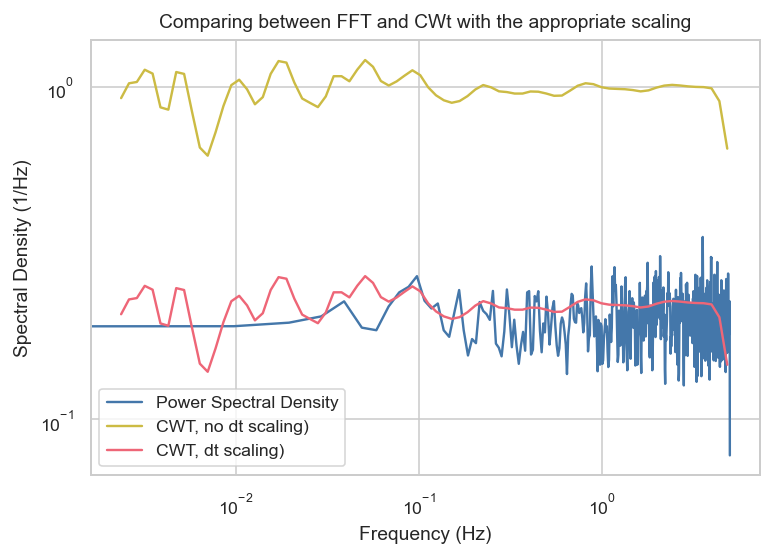

In [19]:
# First use white noise
signal = y_white
signal_var = signal.std() ** 2
mother = pycwt.Morlet()
fs = 10

# Compare to the FFT spectra
s_med, f_med = mlab.psd(signal, NFFT=2**10, Fs=fs)
plt.loglog(f_med, s_med / signal_var, label='Power Spectral Density')

# Perform the CWT analysis for a large number of octaves
octaves = [1 / 7, 11 / (1 / 7)]
dt = 1 / fs
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False, 'remove_mean': False},
    significance_test=False,
)

# Integrate the spectra to determine if it is equal to the variance
print(
    'CWT/sigma**2 / sqrt(dt) = {:1.2f} (no dt scaling)'.format(
        integrate.trapezoid(
            np.flip(power.mean(axis=1)),
            np.flip(1 / period)
        )
    )
)

plt.loglog(1 / period, power.mean(axis=1), label='CWT, no dt scaling)')

# Perform the CWT analysis for a small number of octaves
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False, 'remove_mean': False},
    significance_test=False,
)

# Integrate the spectra to determine if it is equal to the variance
print(
    'CWT/sigma**2 / sqrt(dt) = {:1.2f} (dt scaling)'.format(
        integrate.trapezoid(
            np.flip(power.mean(axis=1)) * np.sqrt(dt / 2),
            np.flip(1 / period)
        )
    )
)

plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt / 2), label='CWT, dt scaling)')

plt.gca().set_title('Comparing between FFT and CWt with the appropriate scaling')
plt.gca().set_ylabel('Spectral Density (1/Hz)')
plt.gca().set_xlabel('Frequency (Hz)')
plt.gca().legend()

## 4.4 Red and Pink Noise

CWT/sigma**2 / sqrt(dt) = 3.81 (no dt scaling)
CWT/sigma**2 / sqrt(dt) = 0.85 (dt scaling)


Text(0.5, 0, 'Frequency (Hz)')

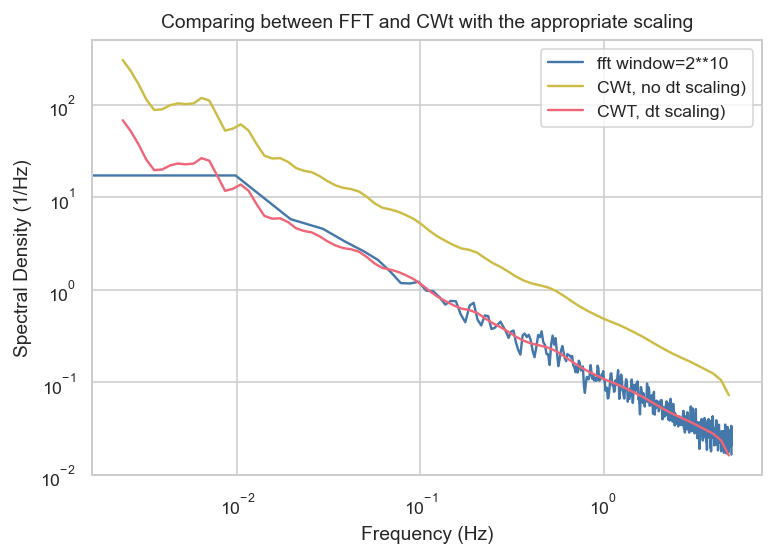

In [40]:
# First use white noise
signal = y_pink
signal_var = signal.std() ** 2
mother = pycwt.Morlet()
fs = 10
dt = 1 / fs

# Compare to the FFT spectra
s_med, f_med = mlab.psd(signal, NFFT=2**10, Fs=fs)
plt.loglog(f_med, s_med / signal_var, label='fft window=2**10')

# Perform the CWT analysis for a large number of octaves
octaves = [1 / 7, 11 / (1 / 7)]  
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False, 'remove_mean': False},
    significance_test=False,
)

# Integrate the spectra to determine if it is equal to the variance
print(
    'CWT/sigma**2 / sqrt(dt) = {:1.2f} (no dt scaling)'.format(
        integrate.trapezoid(
            np.flip(power.mean(axis=1)),
            np.flip(1 / period)
        )
    )
)

plt.loglog(1 / period, power.mean(axis=1), label='CWt, no dt scaling)')

# Perform the CWT analysis for a small number of octaves
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False, 'remove_mean': False},
    significance_test=False,
)

# Integrate the spectra to determine if it is equal to the variance
print(
    'CWT/sigma**2 / sqrt(dt) = {:1.2f} (dt scaling)'.format(
        integrate.trapezoid(
            np.flip(power.mean(axis=1)) * np.sqrt(dt / 2),
            np.flip(1 / period)
        )
    )
)

plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt / 2), label='CWT, dt scaling)')

plt.gca().set_title('Comparing between FFT and CWt with the appropriate scaling')
plt.gca().legend()
plt.gca().set_ylabel('Spectral Density (1/Hz)')
plt.gca().set_xlabel('Frequency (Hz)')

The scaling by $\frac{dt}{2}$ better represents the spectral power and brings the CWT in-line with the PSD.

## 4.5 Comparing spectra with different time steps and properties

### Artificially generate different time steps

Text(0.5, 0, 'Frequency (Hz)')

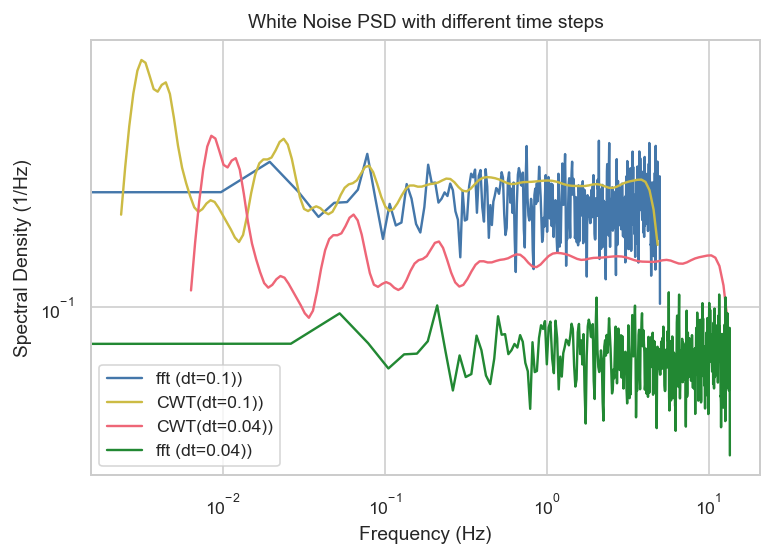

In [42]:
# Make up a sampling frequency in Hz
fs = 10
dt = 1 / fs
# First use white noise
signal = y_white
signal_var = signal.std() ** 2

# Compute the spectral density
s, f = mlab.psd(signal, NFFT=2**10, Fs=fs)
plt.loglog(f, s / signal_var ** 2, label='fft (dt={}))'.format(dt))

# Compute the CWT spectra for one type of time step
mother = pycwt.Morlet()
dt = 1 / fs
time = np.arange(0, N * dt, dt)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt/2), label='CWT(dt={}))'.format(dt))

# Compute the CWT spectra for one type of time step
fs = 27
dt = 1 / fs
octaves = [1 / 12, 11 / (1 / 12)]  
time = np.arange(0, N * dt, dt)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt / 2), label='CWT(dt={:1.2f}))'.format(dt))

# Compute the spectral density
s, f = mlab.psd(signal, NFFT=2**10, Fs=fs)
plt.loglog(f, s / signal_var ** 2, label='fft (dt={:1.2f}))'.format(dt))

plt.gca().set_title('White Noise PSD with different time steps')
plt.gca().legend()
plt.gca().set_ylabel('Spectral Density (1/Hz)')
plt.gca().set_xlabel('Frequency (Hz)')

These should all be identical! What is happening??

## 4.6 Rectifying Spectra

The rectification will be explored in much more detail in the "wavelet-significance" notebook. Here we simply tease how important this step is when comparing the spectra of time series with different time steps.

Text(0.5, 0, 'Frequency (Hz)')

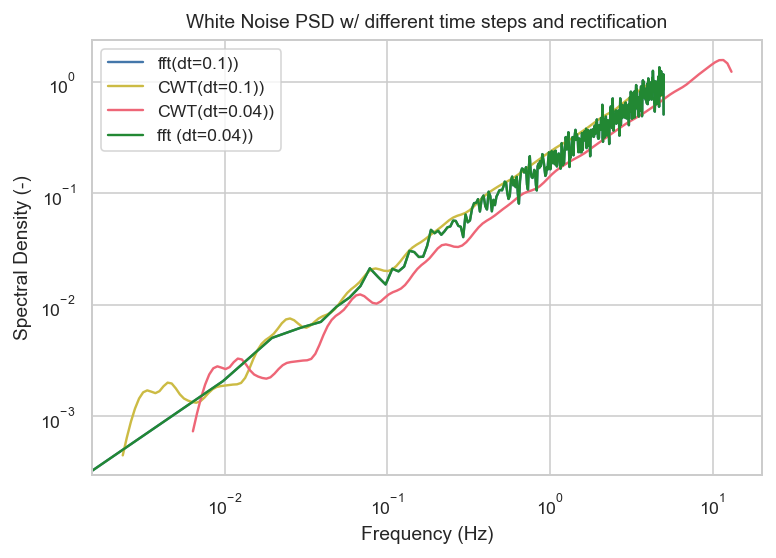

In [47]:
# Make up a sampling frequency in Hz
fs = 10
dt = 1 / fs
# First use white noise
signal = y_white
signal_var = signal.std() ** 2

# Compute the spectral density
s, f = mlab.psd(signal, NFFT=2**10, Fs=fs)
plt.loglog(f, s / signal_var ** 2 * f, label='fft(dt={}))'.format(dt))

# Compute the CWT spectra for one type of time step
mother = pycwt.Morlet()
time = np.arange(0, N * dt, dt)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=True,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt/2), label='CWT(dt={}))'.format(dt))

# Compute the CWT spectra for one type of time step
dt = 1 / 27
octaves = [1 / 12, 11 / (1 / 12)]  
time = np.arange(0, N * dt, dt)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=True,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt / 2), label='CWT(dt={:1.2f}))'.format(dt))

# Compute the spectral density
s, f = mlab.psd(signal, NFFT=2**10, Fs=fs)
plt.loglog(f, s / signal_var ** 2 * f, label='fft (dt={:1.2f}))'.format(dt))

plt.gca().set_title('White Noise PSD w/ different time steps and rectification')
plt.gca().legend()
plt.gca().set_ylabel('Spectral Density (-)')
plt.gca().set_xlabel('Frequency (Hz)')

However, this normalizaiton is not perfect. When using just CWT, I recommend not using the scaling as it disrupts the scaling between otherwise identical spectra.

Text(0.5, 0, 'Frequency (Hz)')

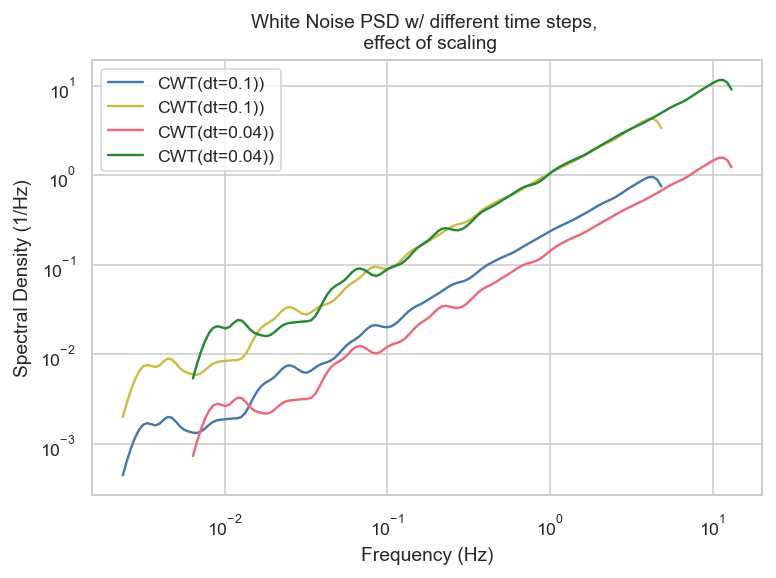

In [45]:
# Make up a sampling frequency in Hz
fs = 10
dt = 1 / fs
# First use white noise
signal = y_white
signal_var = signal.std() ** 2

# Compute the CWT spectra for one type of time step
mother = pycwt.Morlet()
time = np.arange(0, N * dt, dt)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=True,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt/2), label='CWT(dt={}))'.format(dt))
plt.loglog(1 / period, power.mean(axis=1), label='CWT(dt={}))'.format(dt))

# Compute the CWT spectra for one type of time step
dt = 1 / 27
octaves = [1 / 12, 11 / (1 / 12)]  
time = np.arange(0, N * dt, dt)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=signal_var,
    rectify=True,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, power.mean(axis=1) * np.sqrt(dt / 2), label='CWT(dt={:1.2f}))'.format(dt))
plt.loglog(1 / period, power.mean(axis=1), label='CWT(dt={:1.2f}))'.format(dt))

plt.gca().set_title('White Noise PSD w/ different time steps, \n effect of scaling')
plt.gca().legend()
plt.gca().set_ylabel('Spectral Density (-)')
plt.gca().set_xlabel('Frequency (Hz)')

The scaling allows the CWT and FFT spectra to align. However, something is not quite right and the CWT spectra do not completely align. This problem is alleviated when using the CWT spectra with rectification, but a comparison to the FFT spectra is no longer possible.

## Why is this hard to notice?

I'm going to use the tutorial from the PyCWT package (https://pycwt.readthedocs.io/en/latest/tutorial.html), replacing the Nino3 example data with a white noise time series.

In [31]:
import pycwt as wavelet
from pycwt.helpers import find

dat = y_white
N = dat.size
dt = 1 / 10
fs = 1 / dt
t = np.arange(0, N) * dt
std = dat.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat / std  # Normalized dataset
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs
# power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)
s, f = mlab.psd(dat_norm, NFFT=2**10, Fs=fs)


And now to plot. The light grey "mess" is the fft results from the PyCWT package. The blue is the power spectral density.

<ipython-input-32-8dc8f390c97c>:25: RuntimeWarning: divide by zero encountered in true_divide
  cx.plot(np.log2(1. / f), s * var, label='FFT power spectral density')


<Figure size 792x576 with 0 Axes>

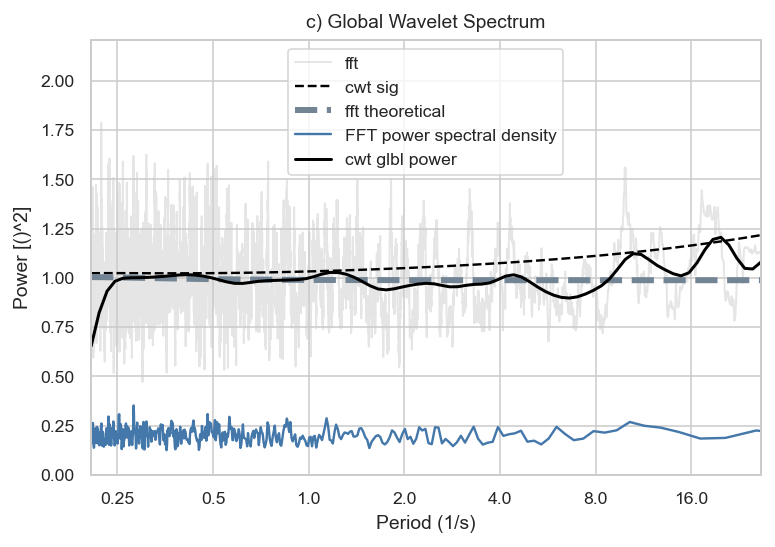

In [32]:
from matplotlib import pyplot
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

title = 'White noise'
label = 'Made up data'
units = ''
Xticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
# Prepare the figure
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
_, cx = plt.subplots(1, 1)
# cx.plot(np.log2(1./fftfreqs), var * fft_power, '-', color='#cccccc', label='fft',
#         linewidth=1., alpha=0.5)
cx.plot(np.log2(1./fftfreqs[29:]), var * moving_average(fft_power, 30), '-', color='#cccccc', label='fft',
        linewidth=1., alpha=0.5)
cx.plot(np.log2(period), glbl_signif, 'k--', label='cwt sig')
cx.plot(np.log2(period), var * fft_theor, '--', color='xkcd:steel', label='fft theoretical', linewidth=3)
cx.plot(np.log2(1. / f), s * var, label='FFT power spectral density')
cx.plot(np.log2(period), var * glbl_power, 'k-', linewidth=1.5, label='cwt glbl power')
cx.legend()
cx.set_title('c) Global Wavelet Spectrum')
cx.set_ylabel(r'Power [({})^2]'.format(units))
cx.set_xlabel('Period (1/s)')
cx.set_ylim([0, glbl_power.max() + var])
cx.set_xlim(np.log2([period.min(), period.max()]))
cx.set_xticks(np.log2(Xticks))
cx.set_xticklabels(Xticks);


The mean values of the CWT and FFT spectrum are 1. But the integral of these spectra is not 1. The integral of the PSD is one, and one must scale the FFT or CWT before comparing to the PSD.